# Arrival Rate Modeling

Author: Greg Strabel

The purpose of this notebook is two-fold; first, to introduce new users to data wrangling in R, specifically using the dplyr and tidyr packages; secondly, to provide insight and modeling suggestions regarding arrival rate processes.

Arrival rate processes are a type of stochastic process used for modeling the occurance of events, for example, the number of customers that request a quote from an insurance company on a given day. Although this rate is a key performance metric, rigorous statistical analysis of it is often lacking. An inability to seperate signal and noise in the data results in wasted resources and poor decisions.

To keep the discussion simple, I consider a data generating process with only two features, State and Market Group, and basic seasonality.

In [291]:
# Load libraries
library(dplyr)
library(ggplot2)
library(tidyr)
library(zoo)
library(timeDate)

In [292]:
#####################################################################
## Create Data
#####################################################################
set.seed(0)

start.date = as.Date("2015/01/01")
end.date = as.Date("2016/12/31")
start.year = as.numeric(format(start.date,'%Y'))
end.year = as.numeric(format(end.date,'%Y'))
regime.change.date = as.Date("2016/04/01")
regime.change.perc = 0.15
holidays = as.Date(holidayNYSE(seq(start.year,end.year)))

## States
states <- as.data.frame(c('New York', 'California', 'Texas', 'Florida'))
colnames(states) <- 'State'
states$statesAnnualFreq <- runif(nrow(states), min = -0.5, max = 0.5)
states$statesSeasonalMagnitude <- runif(nrow(states), min = 0.05, max = 0.15)
states$statesAnnualGrowth <- runif(nrow(states),min = -0.1, max = 0.2)
states$statesDailyArrivals <- 10*runif(nrow(states))
regime.change.state = states[sample(nrow(states),1),]$State
## Market Groups
marketGroups <- as.data.frame(c('Restaurants', 'Business Services', 'Construction', 'Medical Offices'))
colnames(marketGroups) <- 'MarketGroup'
marketGroups$marketGroupsAnnualFreq <- runif(nrow(marketGroups), min = -0.5, max = 0.5)
marketGroups$marketGroupsSeasonalMagnitude <- runif(nrow(marketGroups), min = 0.05, max = 0.15)
marketGroups$marketGroupsAnnualGrowth <- runif(nrow(marketGroups),min = -0.1, max = 0.2)
marketGroups$marketGroupsDailyArrivals <- 10*runif(nrow(marketGroups))
regime.change.marketgroup = marketGroups[sample(nrow(marketGroups),1),]$MarketGroup

## Merge states and market groups
df <- merge(states,marketGroups)
df <- df %>%
  mutate(annualFreq = marketGroupsAnnualFreq + statesAnnualFreq,
         annualGrowth = marketGroupsAnnualGrowth + statesAnnualGrowth,
         dailyArrivals = marketGroupsDailyArrivals + statesDailyArrivals,
         seasonalMagnitude = marketGroupsSeasonalMagnitude + statesSeasonalMagnitude)

## Add dates
df <- merge(df,
    seq(from = start.date, to = end.date, by = "day")
            ) %>% rename(Date = y) %>%
      mutate(dayOfWeek = weekdays(Date),
             year = as.numeric(format(Date,'%Y')))

## Create underlying arrival rate
df <- df %>%
  mutate(dateDiff = as.numeric(Date - start.date) / 365,
         dailyArrivals = dailyArrivals*
           #(1+0.5*cos(dateDiff*annualFreq*2*pi))*
           (1 + 0.1*cos(4*pi*
               as.numeric(Date - as.Date(format(Date,"%Y-01-01")))
               /as.numeric(as.Date(format(Date,"%Y-12-31")) - as.Date(format(Date,"%Y-01-01")))
           ))*
           ifelse(format(Date,"%m")=="01",1+seasonalMagnitude,1)*
           exp(dateDiff*annualGrowth))

## Add regime change component
df[df$State == regime.change.state &
   df$MarketGroup == regime.change.marketgroup &
   df$Date >= regime.change.date, 'dailyArrivals'] <- 
    df[df$State == regime.change.state &
       df$MarketGroup == regime.change.marketgroup &
       df$Date >= regime.change.date, ]$dailyArrivals*(1 + regime.change.perc)

## No arrivals on the weekend or holidays
df[df$dayOfWeek %in% c('Saturday','Sunday'),'dailyArrivals'] <- 0
df[df$Date %in% holidays,'dailyArrivals'] <- 0
df$holiday <- ifelse(df$Date %in% holidays, TRUE, FALSE)

## Draw arrivals from a Poisson distribution
df$Arrivals <- rpois(n=nrow(df),lambda = df$dailyArrivals)

## Create a long and narrow dataframe, removing weekends and holidays
df_long_and_narrow <- df %>% filter(!(dayOfWeek %in% c('Saturday','Sunday')) & (holiday==FALSE)) %>%
    select(State,MarketGroup, Date, Arrivals)

Business analysts are typically familiar with two formats for tabular data; the long-and-narrow format and the flat-and-wide format (this is an oversimplification of possible tabular data structures - in reality, there are a range of tabular models between the two I present here).The long-and-narrow format has one column of values and one or more columns which give context to the value; these columns may comprise a composite key for identifying a specific record. For the data generated above, a long-and-narrow table may look something like:

In [293]:
head(df_long_and_narrow)

State,MarketGroup,Date,Arrivals
New York,Restaurants,2015-01-02,11
California,Restaurants,2015-01-02,24
Texas,Restaurants,2015-01-02,20
Florida,Restaurants,2015-01-02,27
New York,Business Services,2015-01-02,9
California,Business Services,2015-01-02,13


The opposite extreme would be to 'spread' the values of the Arrivals variable out into individual columns for distinct combinations of State and Market Group:

In [294]:
df_flat_and_wide <- df_long_and_narrow %>%
    # Construct a variable for the concatenation of State and Market Group
    mutate(StateAndMarketGroup = paste(State, MarketGroup, sep = ' - ')) %>%
    # Select the relevant columns
    select(Date, StateAndMarketGroup, Arrivals) %>%
    # Spread Arrivals by State and Market Group
    spread(StateAndMarketGroup, Arrivals)

head(df_flat_and_wide)

Date,California - Business Services,California - Construction,California - Medical Offices,California - Restaurants,Florida - Business Services,Florida - Construction,Florida - Medical Offices,Florida - Restaurants,New York - Business Services,New York - Construction,New York - Medical Offices,New York - Restaurants,Texas - Business Services,Texas - Construction,Texas - Medical Offices,Texas - Restaurants
2015-01-02,13,15,15,24,7,11,16,27,9,10,10,11,12,11,11,20
2015-01-05,11,13,19,14,14,14,21,21,10,8,5,14,15,13,12,21
2015-01-06,15,14,16,17,10,17,12,30,13,5,12,16,9,20,10,14
2015-01-07,10,16,13,21,17,17,21,25,5,12,10,20,7,10,17,26
2015-01-08,17,11,18,18,15,20,19,28,6,7,15,13,12,15,8,19
2015-01-09,10,13,16,24,17,14,16,18,4,12,10,18,6,17,6,14


It is equally easy to transform the flat and wide model back to long and narrow:

In [295]:
df_flat_and_wide %>%
    # Gather all the State and Market Group columns into key and value columns
    gather('StateAndMarketGroup', 'Arrivals',2:ncol(df_flat_and_wide)) %>%
    # Split the keys into State and Market Group
    separate(StateAndMarketGroup, c('State','MarketGroup'), sep = ' - ') %>%
    head()

Date,State,MarketGroup,Arrivals
2015-01-02,California,Business Services,13
2015-01-05,California,Business Services,11
2015-01-06,California,Business Services,15
2015-01-07,California,Business Services,10
2015-01-08,California,Business Services,17
2015-01-09,California,Business Services,10


Using ggplot2, we can plot Arrivals by facets of the States and Market Groups:

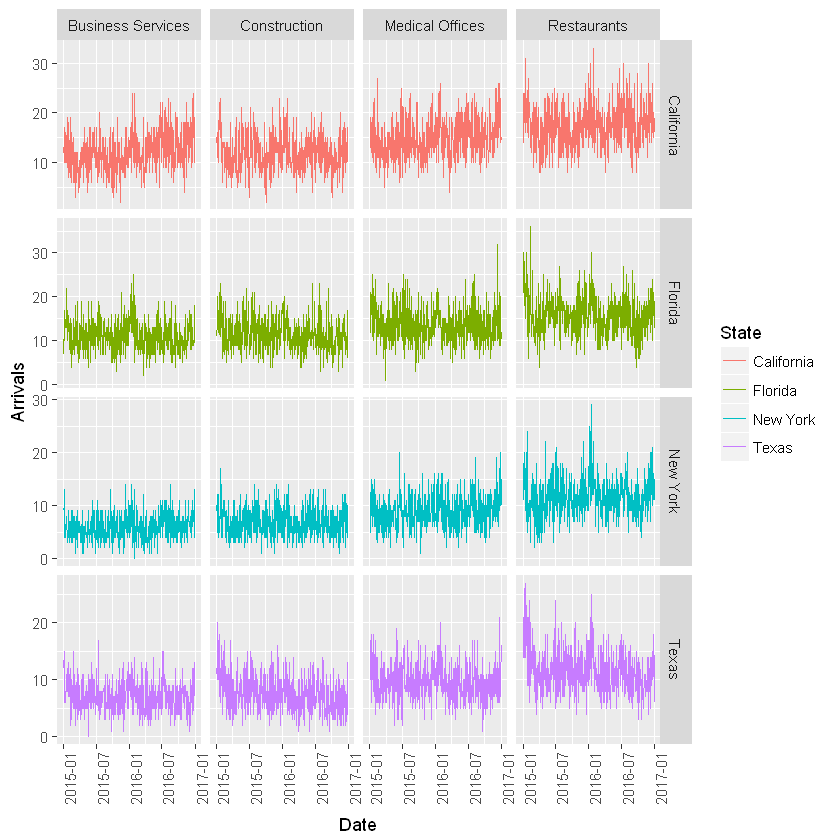

In [296]:
df_long_and_narrow %>%
    ggplot(aes(Date,Arrivals,group=State,color=State)) +
    geom_line() +
    facet_grid(State ~ MarketGroup, scales = 'free_y') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Example of grouping and summarizing

To reduce the daily noise, we can group by State, Market Group, year and month and take the average value:

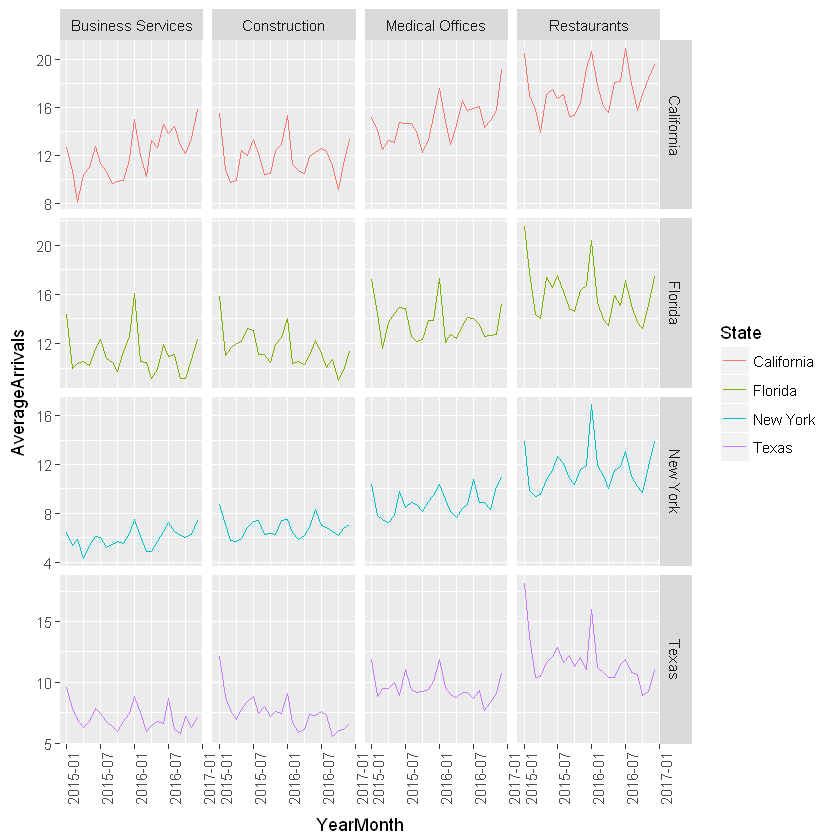

In [297]:
df_long_and_narrow %>%
    # Map all dates to the first of the month
    mutate(YearMonth = as.Date(format(Date,'%Y-%m-01'))) %>%
    group_by(State, MarketGroup, YearMonth) %>%
    summarise(AverageArrivals = mean(Arrivals)) %>%
    ggplot(aes(YearMonth,AverageArrivals,group=State,color=State)) +
    geom_line() +
    facet_grid(State ~ MarketGroup, scales = 'free_y') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Example of split-apply-combine

Rather than calculate the mean by month, one may want to calculate a mean within a 20-day rolling window:

Warning message:
"Removed 76 rows containing missing values (geom_path)."

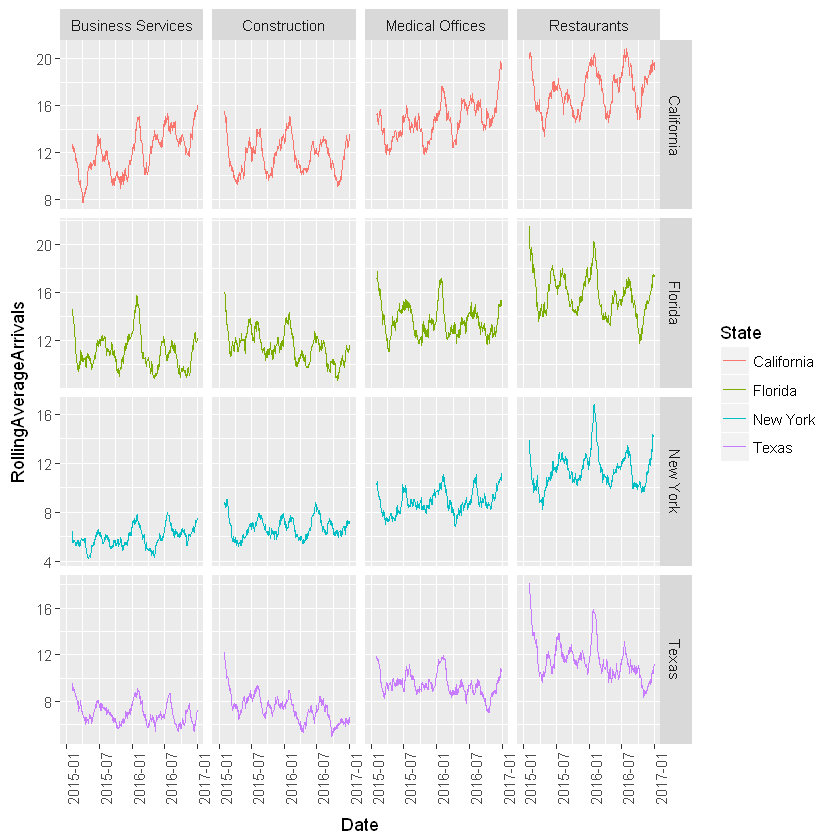

In [298]:
df_long_and_narrow %>%
    group_by(State, MarketGroup) %>%
    arrange(State, MarketGroup, Date) %>%
    # Calculate rolling 20-day average
    mutate(RollingAverageArrivals = rollapply(data = Arrivals, width = 20, FUN = mean, align = "right", fill = NA)) %>%
    ggplot(aes( Date, RollingAverageArrivals, group = State, color = State)) +
    geom_line() +
    facet_grid(State ~ MarketGroup, scales = 'free_y') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

Lastly, one may want to calculate the cumulative arrivals by State and Market Group for a given month year over year:

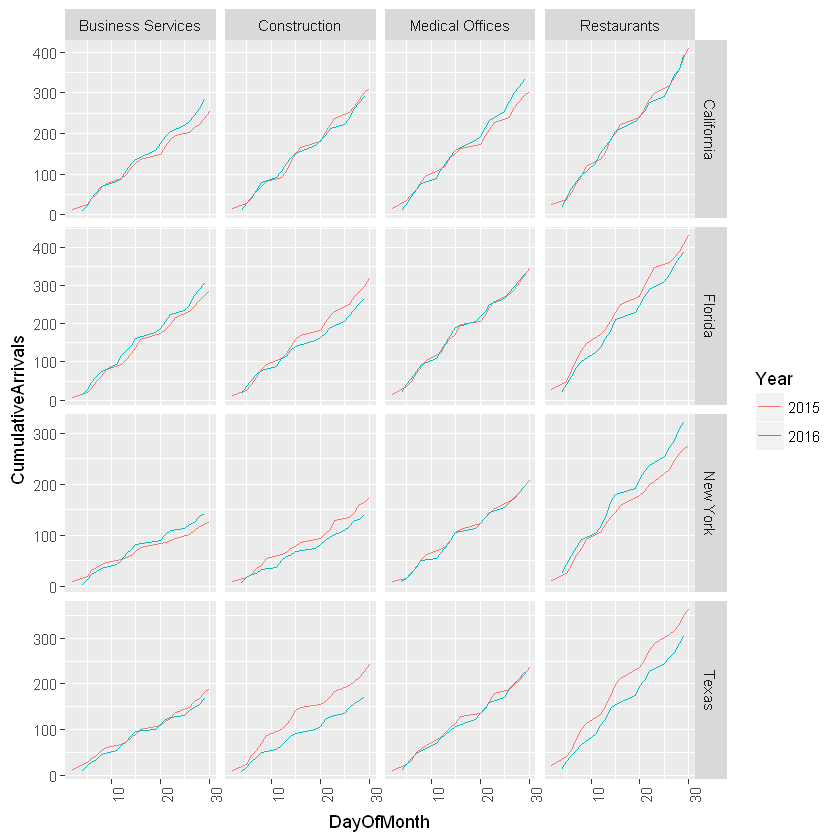

In [299]:
df_long_and_narrow %>%
    # Parse dates into year, month and day
    mutate(Year = format(Date,'%Y'),
           Month = format(Date,'%m'),
          DayOfMonth = as.numeric(format(Date,'%d'))) %>%
    group_by(State, MarketGroup, Year, Month) %>%
    arrange(State, MarketGroup, Date) %>%
    # Apply cumulative sum
    mutate(CumulativeArrivals = cumsum(Arrivals)) %>%
    # filter to January
    filter(format(Date,'%m') == '01') %>%
    ggplot(aes(DayOfMonth, CumulativeArrivals, group=Year, color=Year)) +
    geom_line() +
    facet_grid(State ~ MarketGroup, scales = 'free_y') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

### Poisson Regression:

The first model we will consider for the arrival data is a Poisson regression. This model assumes that arrivals for market group $i$ and state $j$ at time $t$ are Poisson distributed with mean $\lambda_{ijt}$ such that $\ln \lambda_{ijt} = \sum_{k=1}^K \beta_k g_k\left( x_{ijt} \right)$ where $\left\{ g_k \right\}$ are known functions and $\left\{ x_{ijt} \right\}$ is a vector of indicators of market group, indicators of state and time.

Warning message:
"Removed 19 rows containing missing values (geom_path)."

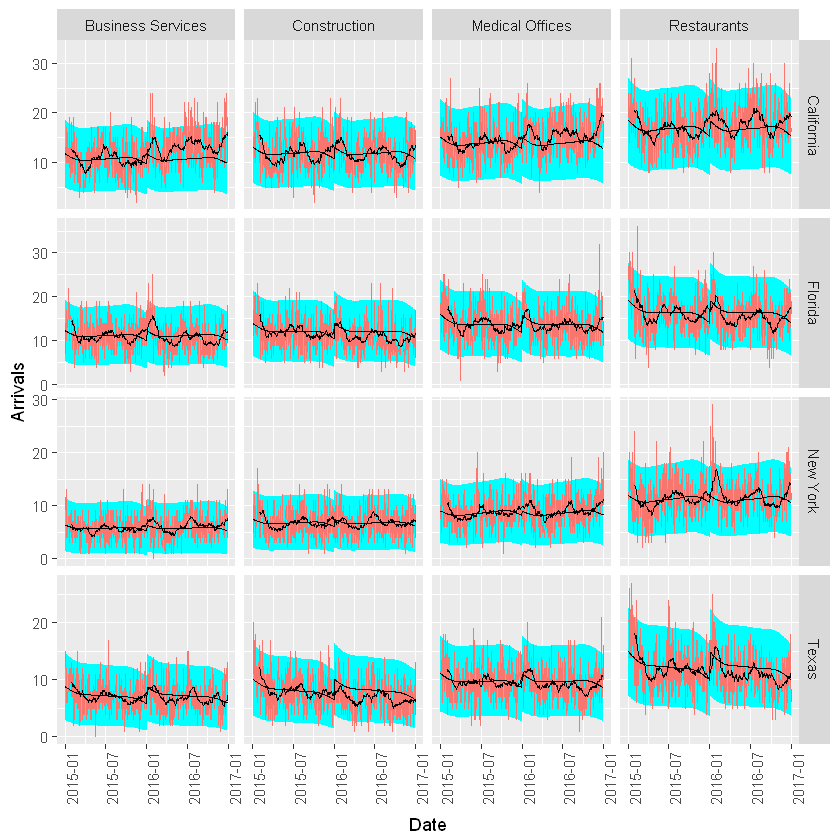

In [300]:
library(glmnet)

df_long_and_narrow <- df_long_and_narrow %>%
    mutate(firstDayOfYear = as.Date(paste(as.character(format(Date,'%Y')),'-01-01',sep='')),
           lastDayOfYear = as.Date(paste(as.character(format(Date,'%Y')),'-12-31',sep='')),
        t = as.numeric(Date - firstDayOfYear) / as.numeric(lastDayOfYear - firstDayOfYear)) %>%
    select(-firstDayOfYear, -lastDayOfYear)

train <- df_long_and_narrow %>% filter(as.numeric(format(Date,'%Y')) == start.year)

cv.glmnet.fit <- cv.glmnet(x = model.matrix(Arrivals ~ State + MarketGroup +
                            t + sin(2*pi*t) + sin(4*pi*t) + t*State + t*MarketGroup + 
                            State*MarketGroup + t*State*MarketGroup, train),
       y = train$Arrivals,
       family = "poisson",
       alpha = 0.5)

df_long_and_narrow$ElasticNetGLM <- predict(cv.glmnet.fit, s="lambda.min",
    newx = model.matrix(Arrivals ~ State + MarketGroup +
                            t + sin(2*pi*t) + sin(4*pi*t) + t*State + t*MarketGroup + 
                            State*MarketGroup + t*State*MarketGroup, df_long_and_narrow),
    type = 'response')[,1]

df_long_and_narrow %>%
    group_by(State, MarketGroup) %>%
    arrange(State,MarketGroup,Date) %>%
    # Calculate rolling 20-day average
    mutate(RollingAverageArrivals = rollapply(data = Arrivals, width = 20, FUN = mean, align = "right", fill=NA)) %>%
    ggplot() +
    geom_ribbon(aes(x=Date, ymin = ElasticNetGLM - 2 * sqrt(ElasticNetGLM),
                    ymax = ElasticNetGLM + 2 * sqrt(ElasticNetGLM)), fill = 'cyan') +
    geom_line(aes(Date,Arrivals, color = 'red')) +
    geom_line(aes(Date,ElasticNetGLM)) +
    geom_line(aes(Date, RollingAverageArrivals)) +
    facet_grid(State ~ MarketGroup, scales = 'free') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
         legend.position = 'none')

### Poisson Process With Latent Autoregressive Mean

A second option is to model Arrivals as a Poisson process with a latent autoregressive mean of the form:
$$\ln \lambda_{ijt} = \sum_{k=1}^K \beta_{ijk} g_k \left( x_{ijt} \right) + \sum_{p=1}^P \alpha_{ijp} A_{ij(t-p)} + \sum_{q=1}^Q \gamma_{ijq} \ln \lambda_{ij(t-q)}$$

In [301]:
library(tscount)
tsglmObjects = list()
combos <- df_long_and_narrow %>% select(State, MarketGroup) %>% unique() #%>% head(2)
for(i in 1:nrow(combos)){
    state = as.character(combos[i,1])
    marketgroup = as.character(combos[i,2])
    # Construct train
    df_train <- df_long_and_narrow %>% filter(State == state, MarketGroup == marketgroup,
                                             format(df_long_and_narrow$Date,'%Y') == start.year) %>% arrange(Date)
    # Fit train
    tsglmObjects[[paste(c(state,marketgroup),collapse = ' ')]] <- tsglm(df_train$Arrivals,
                      model=list(past_obs = seq(1,2), past_mean = seq(1,3)),
                      xreg = model.matrix(~ t + sin(2*pi*t) + sin(4*pi*t), df_train),
                      distr = "poisson",
                      link = "log")
    # Assign fitted values to train records
    df_long_and_narrow[df_long_and_narrow$State==state &
                        df_long_and_narrow$MarketGroup == marketgroup &
                        as.numeric(format(df_long_and_narrow$Date,'%Y')) == start.year, 'tsGLMPred'] <- 
    tsglmObjects[[paste(c(state,marketgroup),collapse = ' ')]]$fitted.values
    # Construct test
    df_test = df_long_and_narrow %>% filter(State == state,
                                            MarketGroup == marketgroup,
                                            as.numeric(format(Date,'%Y')) > start.year) %>% arrange(Date)
    # Assign predicted values to test records
    df_long_and_narrow[df_long_and_narrow$State==state &
                        df_long_and_narrow$MarketGroup == marketgroup &
                        as.numeric(format(df_long_and_narrow$Date,'%Y')) > start.year, 'tsGLMPred'] <- 
    predict(tsglmObjects[[paste(c(state,marketgroup),collapse = ' ')]],
            newxreg = model.matrix(~ t + sin(2*pi*t) + sin(4*pi*t), df_test), n.ahead = nrow(df_test))$pred
}

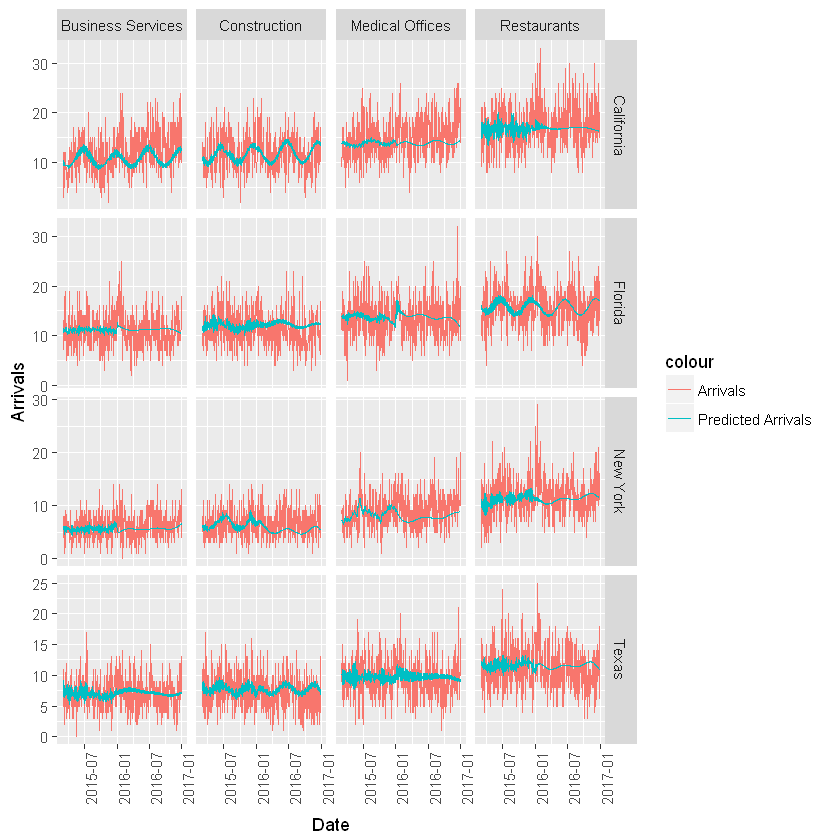

In [302]:
df_long_and_narrow %>%
    filter(Date >= start.date + 60) %>%
    group_by(State, MarketGroup) %>%
    arrange(State,MarketGroup,Date) %>%
    # Calculate rolling 20-day average
    mutate(Right20 = rollapply(data = Arrivals, width = 30, FUN = mean, align = "right", fill=NA),
          Left20 = rollapply(data = Arrivals, width = 30, FUN = mean, align = "left", fill=NA),
          diff = 2*(Right20 - Left20)/(Right20 + Left20)) %>%
    ggplot() +
    geom_line(aes(Date,Arrivals, color = 'Arrivals')) +
    geom_line(aes(Date,tsGLMPred, color = 'Predicted Arrivals')) +
    facet_grid(State ~ MarketGroup, scales = 'free') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

### TODO:

    1. Adapt a PEWMA (Poisson Exponential Weighted Moving Average) model - see Brandt et al. 2000. "Dynamic Modelling for Persistent Event Count Time Series." American Journal of Political Science. 44(4): 823-843.
    
    2. Adapt a PAR (Poisson Autoregression) model - see Brandt and Williams. 2001. "A Linear Poisson Autoregressive Model: The PAR(p)"  Political Analysis 9(2).